# Seasonal Clustering


In [23]:
# Jupyter notebook: optional formatting extension
# %load_ext nb_black

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import os
import datetime
import math
from math import ceil

# Preprocessing
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.impute import KNNImputer

# Clustering
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, MeanShift, estimate_bandwidth
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import NearestNeighbors, LocalOutlierFactor

# Clustering evaluation
from sklearn.metrics import silhouette_score, silhouette_samples, davies_bouldin_score, calinski_harabasz_score

# Hierarchical clustering
from scipy.cluster.hierarchy import dendrogram, linkage

# Stats
from scipy.stats import chi2_contingency, stats
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.mosaicplot import mosaic

# Dimensionality reduction
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Model selection
from sklearn.model_selection import GridSearchCV

# Geospatial
from geopy.geocoders import Nominatim
from geopy.distance import geodesic
import geopandas as gpd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import plotly.express as px
import matplotlib.cm as cm


In [24]:
df_seasonal = pd.read_csv("df_ready_for_clustering.csv")
df_seasonal.head()

,PointsRedeemedRatio,FlightsWithCompanionsRatio,AvgDistancePerFlight,KMPerRedeemedPoint,UnredeemedPoints,LoyaltyIndex,CustomerSegment,HasBonus,TotalFlights,sr_jan,...,Education,Income,Marital Status,LoyaltyStatus,EnrollmentMonth,Time on Program,Cancelled,Reenroll,EnrollmentType,Customer Lifetime Value
0,0.387904,0.200000,2356.577778,25.786888,32446,709.589704,Moderate traveler and high redeemed,0,225,0.026667,...,Bachelor,82877.0,Married,Aurora,8,874,N,0,Standard,7919.20
1,0.553363,0.224490,1384.141224,18.077435,15141,418.130598,Low traveler and low redeemed,0,245,0.077551,...,College,0.0,Single,Nova,3,2122,N,0,Standard,2887.74
2,0.113362,0.241706,2047.539336,88.241585,38293,616.640254,Moderate traveler and low redeemed,0,211,0.094787,...,College,0.0,Divorced,Nova,7,884,N,0,Standard,2838.07
3,0.354092,0.157407,3375.941667,28.248369,23544,1014.088728,High traveler and high redeemed,0,108,0.000000,...,Bachelor,42837.0,Married,Star,8,1242,N,0,Standard,4170.57
4,0.253580,0.276243,2373.649171,39.448214,32058,714.181936,Moderate traveler and high redeemed,0,181,0.022099,...,Bachelor,80979.0,Divorced,Star,1,1816,N,0,Standard,6622.05


In [25]:
# I just want the features with sr
df_seasonal = df_seasonal[[ 'sr_jan', 'sr_feb', 'sr_mar', 'sr_apr', 'sr_may', 'sr_jun',
       'sr_jul', 'sr_aug', 'sr_sep', 'sr_oct', 'sr_nov', 'sr_dec']]
df_seasonal.head()


,sr_jan,sr_feb,sr_mar,sr_apr,sr_may,sr_jun,sr_jul,sr_aug,sr_sep,sr_oct,sr_nov,sr_dec
0,0.026667,0.040000,0.146667,0.053333,0.000000,0.031111,0.124444,0.084444,0.137778,0.075556,0.155556,0.124444
1,0.077551,0.024490,0.114286,0.106122,0.028571,0.032653,0.057143,0.106122,0.110204,0.081633,0.122449,0.138776
2,0.094787,0.000000,0.066351,0.104265,0.090047,0.066351,0.104265,0.052133,0.180095,0.018957,0.090047,0.132701
3,0.000000,0.111111,0.027778,0.000000,0.000000,0.074074,0.000000,0.074074,0.222222,0.185185,0.027778,0.277778
4,0.022099,0.027624,0.165746,0.143646,0.038674,0.226519,0.060773,0.088398,0.005525,0.022099,0.088398,0.110497


In [26]:
df_seasonal.isna().sum()

sr_jan    0
sr_feb    0
sr_mar    0
sr_apr    0
sr_may    0
sr_jun    0
sr_jul    0
sr_aug    0
sr_sep    0
sr_oct    0
sr_nov    0
sr_dec    0
dtype: int64

In [27]:
# Normalize numerical columns
numerical_columns = df_seasonal.select_dtypes(include=['int64', 'float64']).columns.tolist()
scaler = MinMaxScaler()
df_seasonal[numerical_columns] = scaler.fit_transform(df_seasonal[numerical_columns])
df_seasonal.head()

,sr_jan,sr_feb,sr_mar,sr_apr,sr_may,sr_jun,sr_jul,sr_aug,sr_sep,sr_oct,sr_nov,sr_dec
0,0.026667,0.040000,0.146667,0.053333,0.000000,0.031111,0.124444,0.084444,0.137778,0.075556,0.155556,0.124444
1,0.077551,0.024490,0.114286,0.106122,0.028571,0.032653,0.057143,0.106122,0.110204,0.081633,0.122449,0.138776
2,0.094787,0.000000,0.066351,0.104265,0.090047,0.066351,0.104265,0.052133,0.180095,0.018957,0.090047,0.132701
3,0.000000,0.111111,0.027778,0.000000,0.000000,0.074074,0.000000,0.074074,0.222222,0.185185,0.027778,0.277778
4,0.022099,0.027624,0.165746,0.143646,0.038674,0.226519,0.060773,0.088398,0.005525,0.022099,0.088398,0.110497


## Hierarchical Clustering

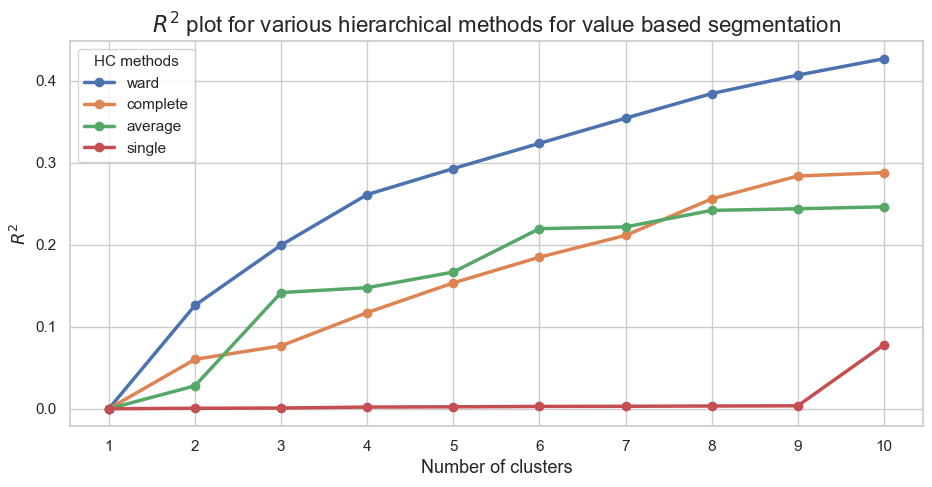

In [28]:

def get_ss(df, feats):
    """Compute total sum of squares (SST) for features in df."""
    X = df[feats].values
    mean_vec = X.mean(axis=0)
    return ((X - mean_vec)**2).sum()

def get_ssw(df, feats, label_col):
    """Compute sum of squares within clusters (SSW)."""
    X = df[feats].values
    labels = df[label_col].values
    ssw = 0
    for lbl in np.unique(labels):
        cluster_points = X[labels == lbl]
        cluster_mean = cluster_points.mean(axis=0)
        ssw += ((cluster_points - cluster_mean)**2).sum()
    return ssw

def get_rsq(df, feats, label_col):
    """Compute R² for clustering solution."""
    sst = get_ss(df, feats)
    ssw = get_ssw(df, feats, label_col)
    ssb = sst - ssw
    return ssb / sst


def get_r2_hc(df, link_method, max_nclus, min_nclus=1, dist="euclidean"):
    """Compute R² for a range of cluster solutions."""
    r2 = []
    feats = df.columns.tolist()
    
    for i in range(min_nclus, max_nclus + 1):
        cluster = AgglomerativeClustering(
            n_clusters=i,
            metric=dist,
            linkage=link_method
        )
        hclabels = cluster.fit_predict(df[feats])
        df_concat = pd.concat([df, pd.Series(hclabels, name='labels', index=df.index)], axis=1)
        r2.append(get_rsq(df_concat, feats, 'labels'))
    
    return np.array(r2)


metric_features = df_seasonal.columns.tolist()  # your numeric features for clustering
hc_methods = ["ward", "complete", "average", "single"]
max_nclus = 10

results = []

for link in hc_methods:
    r2 = get_r2_hc(
        df=df_seasonal[metric_features],
        link_method=link,
        max_nclus=max_nclus,
        min_nclus=1,
        dist="euclidean"
    )
    results.append(r2)

r2_hc = np.vstack(results)


sns.set(style="whitegrid")
plt.figure(figsize=(11,5))

for i, link in enumerate(hc_methods):
    plt.plot(range(1, max_nclus + 1), r2_hc[i], marker='o', linewidth=2.5, label=link)

plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("$R^2$", fontsize=13)
plt.xticks(range(1, max_nclus + 1))
plt.title("$R^2$ plot for various hierarchical methods for value based segmentation", fontsize=16)
plt.legend(title="HC methods", title_fontsize=11)
plt.show()



In [29]:
from scipy.cluster.hierarchy import linkage
# setting distance_threshold=0 and n_clusters=None ensures we compute the full tree
distance = 'euclidean' 
n_clusters = None 

linkage_matrix= linkage(df_seasonal, method="ward") 

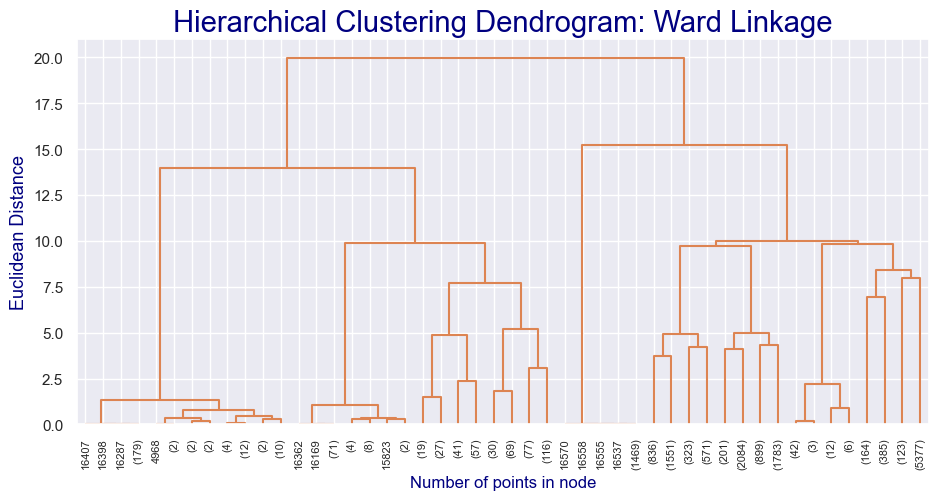

In [30]:
# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned
Y_THRESHOLD = 100 
dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=Y_THRESHOLD, above_threshold_color='navy')
    # You can play with 'truncate_mode' and 'p' define what level the dendrogram shows
    # above_threshold_color='k' forces black color for the lines above the threshold)
plt.hlines(Y_THRESHOLD, 0, 1000, colors="royalblue", linestyles="dashed")
plt.title(f'Hierarchical Clustering Dendrogram: Ward Linkage', fontsize=21, color='navy')
plt.xlabel('Number of points in node', color='navy')
plt.ylabel(f'{distance.title()} Distance', fontsize=13, color='navy')
plt.show()

In [31]:
# Test with nclusters=3
hc = AgglomerativeClustering(
    n_clusters=3,
    metric='euclidean',
    linkage='ward'
)
hc_labels3 = hc.fit_predict(df_seasonal)



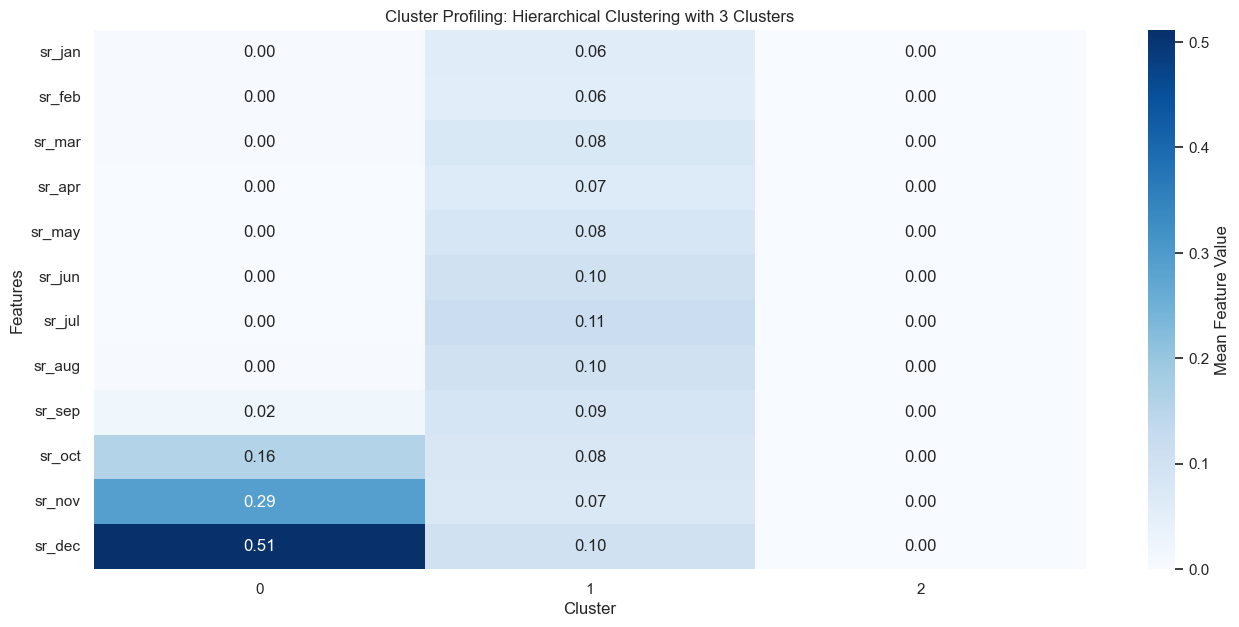

In [32]:
X = df_seasonal.copy()
X['labels'] = hc_labels3

cluster_means = X.groupby('labels')[df_seasonal.columns].mean().T

plt.figure(figsize=(16,7))
sns.heatmap(
    cluster_means,
    cmap="Blues",
    annot=True,
    fmt=".2f",
    cbar_kws={'label': 'Mean Feature Value'}
)
plt.xlabel("Cluster")
plt.ylabel("Features")
plt.title("Cluster Profiling: Hierarchical Clustering with 3 Clusters")
plt.yticks(rotation=0)
plt.show()


In [33]:
# Now do the same but for nclusters=4
hc = AgglomerativeClustering(
    n_clusters=4,
    metric='euclidean',
    linkage='ward'
)
hc_labels4 = hc.fit_predict(df_seasonal)


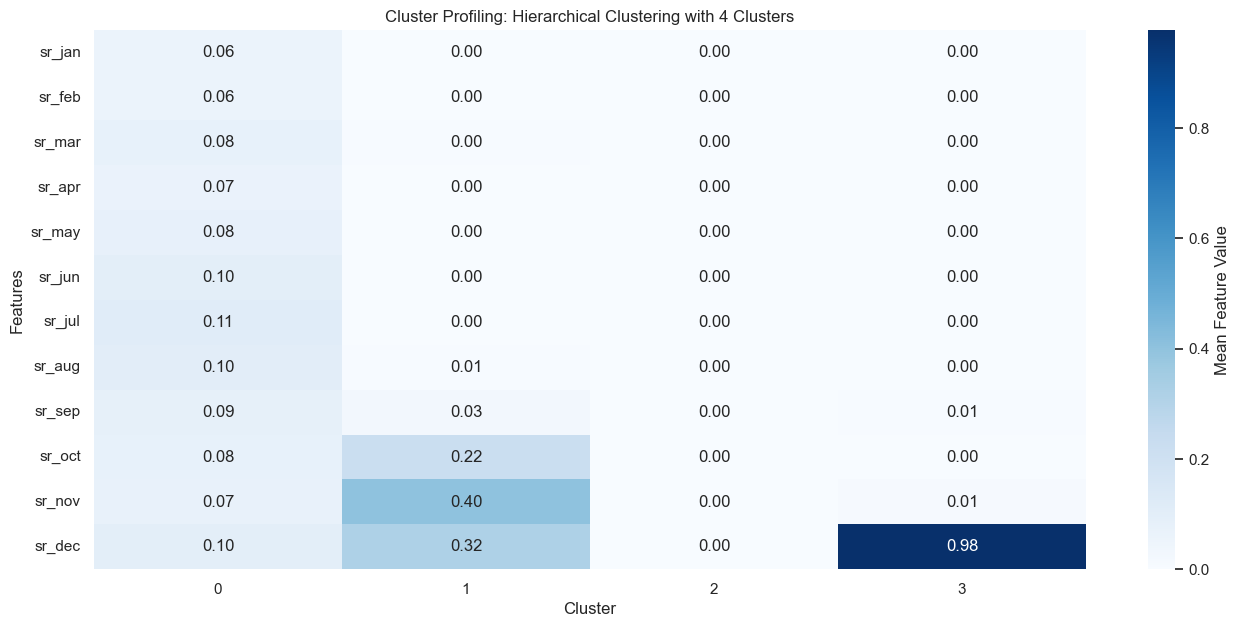

In [34]:
X = df_seasonal.copy()
X['labels'] = hc_labels4

cluster_means = X.groupby('labels')[df_seasonal.columns].mean().T

plt.figure(figsize=(16,7))
sns.heatmap(
    cluster_means,
    cmap="Blues",
    annot=True,
    fmt=".2f",
    cbar_kws={'label': 'Mean Feature Value'}
)
plt.xlabel("Cluster")
plt.ylabel("Features")
plt.title("Cluster Profiling: Hierarchical Clustering with 4 Clusters")
plt.yticks(rotation=0)
plt.show()


In [35]:
# Now nclusters=5
hc = AgglomerativeClustering(
    n_clusters=5,
    metric='euclidean',
    linkage='ward'
)
hc_labels5 = hc.fit_predict(df_seasonal)


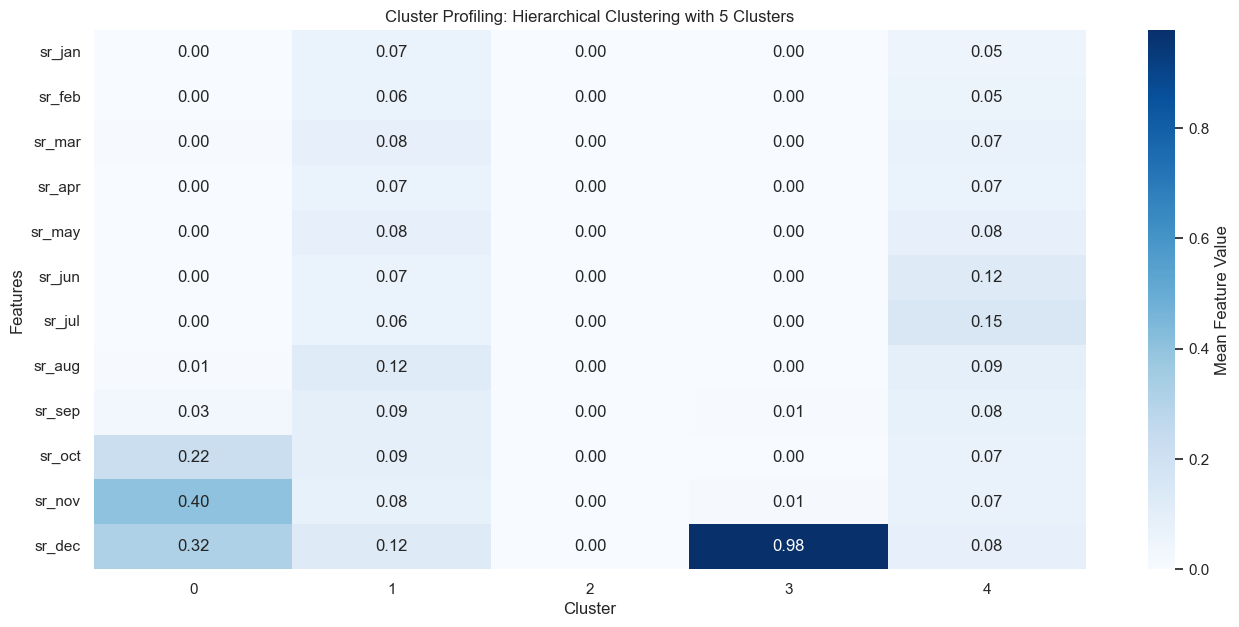

In [36]:
X = df_seasonal.copy()
X['labels'] = hc_labels5

cluster_means = X.groupby('labels')[df_seasonal.columns].mean().T

plt.figure(figsize=(16,7))
sns.heatmap(
    cluster_means,
    cmap="Blues",
    annot=True,
    fmt=".2f",
    cbar_kws={'label': 'Mean Feature Value'}
)
plt.xlabel("Cluster")
plt.ylabel("Features")
plt.title("Cluster Profiling: Hierarchical Clustering with 5 Clusters")
plt.yticks(rotation=0)
plt.show()


## KMEANS

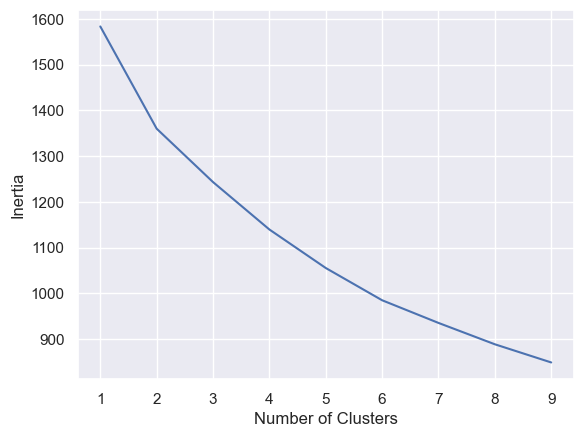

In [ ]:
# Lets use the elbow method to find the best number of clusters

n_clusters = range(1, 10)
sse2 = []

for k in n_clusters:
    km = KMeans(n_clusters=k, init = "k-means++", max_iter=300, n_init=10)
    km.fit(df_seasonal)
    sse2.append(km.inertia_)

plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.plot(n_clusters, sse2)  
plt.show()


cluster,0,1,2,3
sr_jan,0.008394,0.058433,0.048713,0.004231
sr_feb,0.008577,0.055771,0.049755,0.002988
sr_mar,0.007974,0.074122,0.066871,0.004049
sr_apr,0.010180,0.061334,0.060317,0.003753
sr_may,0.012095,0.074444,0.076609,0.004028
sr_jun,0.012558,0.090353,0.096524,0.003771
sr_jul,0.014120,0.039902,0.193531,0.005140
sr_aug,0.033100,0.091002,0.097828,0.014486
sr_sep,0.094347,0.075155,0.076975,0.026394
sr_oct,0.218785,0.067438,0.074039,0.049618


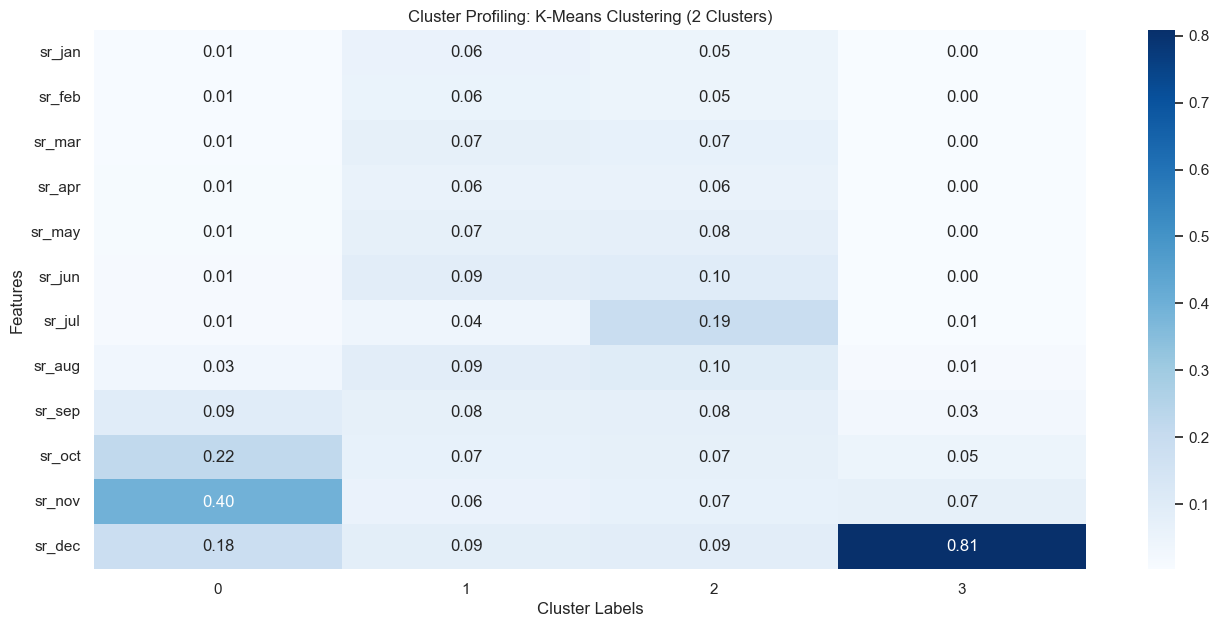

In [ ]:
km = KMeans(n_clusters=4, init="k-means++", random_state=94)
km_labels_4 = km.fit_predict(df_seasonal)

df_value_based_with_clusters = df_seasonal.copy()
df_value_based_with_clusters['cluster'] = km_labels_4

cluster_profile_orig = df_value_based_with_clusters.groupby('cluster').mean()

display(cluster_profile_orig.T)

plt.figure(figsize=(16,7))
sns.heatmap(cluster_profile_orig.T, cmap="Blues", annot=True, fmt=".2f")
plt.title("Cluster Profiling: K-Means Clustering (4 Clusters)")
plt.xlabel("Cluster Labels")
plt.ylabel("Features")
plt.show()

cluster,0,1,2,3,4
sr_jan,0.007715,0.059598,0.050641,0.004084,0.039398
sr_feb,0.007492,0.059872,0.051540,0.002958,0.024095
sr_mar,0.007458,0.086546,0.068084,0.003644,0.000413
sr_apr,0.009099,0.072684,0.060587,0.003637,0.000204
sr_may,0.010526,0.089024,0.076337,0.003675,0.000058
sr_jun,0.011143,0.110199,0.093588,0.003733,0.000000
sr_jul,0.012137,0.054836,0.202549,0.005088,0.000000
sr_aug,0.027137,0.112601,0.093411,0.014313,0.000000
sr_sep,0.089641,0.092389,0.074230,0.027378,0.000000
sr_oct,0.227529,0.081340,0.074284,0.049835,0.000000


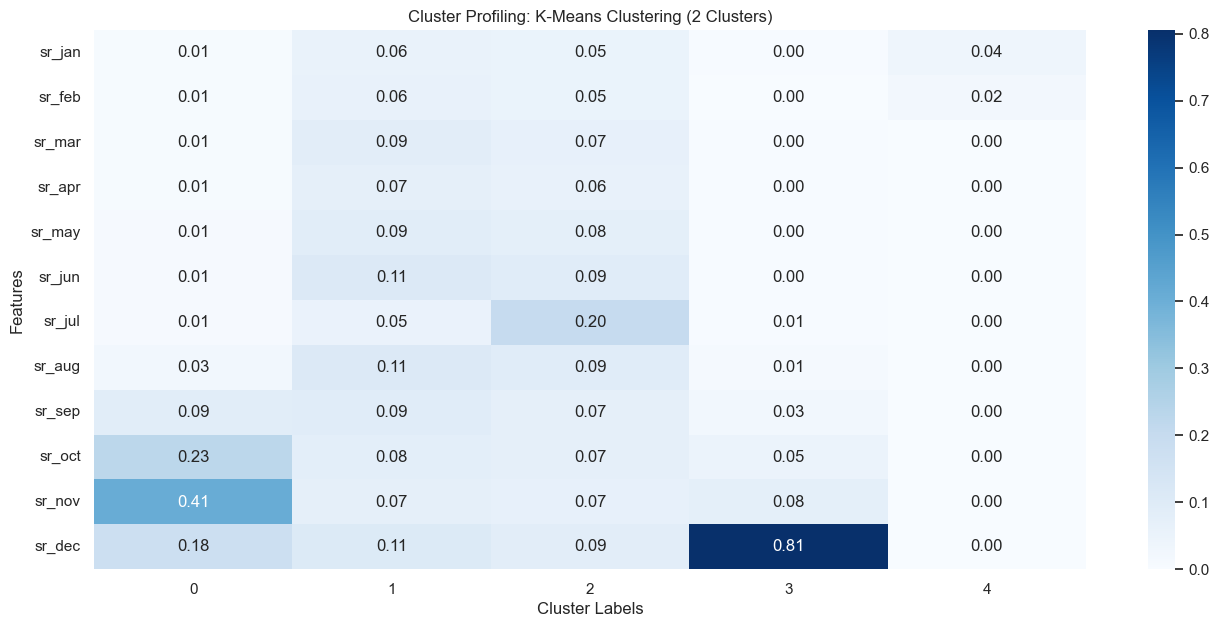

In [ ]:
km = KMeans(n_clusters=5, init="k-means++", random_state=94)
km_labels_5 = km.fit_predict(df_seasonal)

df_value_based_with_clusters = df_seasonal.copy()
df_value_based_with_clusters['cluster'] = km_labels_5

cluster_profile_orig = df_value_based_with_clusters.groupby('cluster').mean()

display(cluster_profile_orig.T)

plt.figure(figsize=(16,7))
sns.heatmap(cluster_profile_orig.T, cmap="Blues", annot=True, fmt=".2f")
plt.title("Cluster Profiling: K-Means Clustering (5 Clusters)")
plt.xlabel("Cluster Labels")
plt.ylabel("Features")
plt.show()

In [41]:
# Now let's compare all results for all different methods and nclusters
X = df_seasonal.copy()
X['hc_3'] = hc_labels3
X['hc_4'] = hc_labels4
X['hc_5'] = hc_labels5
X['km_4'] = km_labels_4
X['km_5'] = km_labels_5
# Features used for clustering
X = df_seasonal.copy()
# Compute metrics for KMeans with 2 clusters
kmeans_4_silhouette = silhouette_score(X, km_labels_4)
kmeans_4_calinski_harabasz = calinski_harabasz_score(X, km_labels_4)
kmeans_4_davies_bouldin = davies_bouldin_score(X, km_labels_4)
# Compute metrics for KMeans with 3 clusters
kmeans_5_silhouette = silhouette_score(X, km_labels_5)
kmeans_5_calinski_harabasz = calinski_harabasz_score(X, km_labels_5)
kmeans_5_davies_bouldin = davies_bouldin_score(X, km_labels_5)

comparison_table = pd.DataFrame({
    "Clustering Method": ["Hierarchical (4 Clusters)", "Hierarchical (3 Clusters)", "Hierarchical (5 Clusters)", "K-Means (4 Clusters)", "K-Means (5 Clusters)"],
    "Silhouette Score": [silhouette_score(X, hc_labels4), silhouette_score(X, hc_labels3), silhouette_score(X, hc_labels5), kmeans_4_silhouette, kmeans_5_silhouette],
    "Calinski-Harabasz Index": [calinski_harabasz_score(X, hc_labels4), calinski_harabasz_score(X, hc_labels3), calinski_harabasz_score(X, hc_labels5), kmeans_4_calinski_harabasz, kmeans_5_calinski_harabasz],
    "Davies-Bouldin Index": [davies_bouldin_score(X, hc_labels4), davies_bouldin_score(X, hc_labels3), davies_bouldin_score(X, hc_labels5), kmeans_4_davies_bouldin, kmeans_5_davies_bouldin]
})
comparison_table.head(6)

,Clustering Method,Silhouette Score,Calinski-Harabasz Index,Davies-Bouldin Index
0,Hierarchical (4 Clusters),0.188484,1951.557057,1.091210
1,Hierarchical (3 Clusters),0.180533,2064.173463,1.221365
2,Hierarchical (5 Clusters),0.155851,1714.612688,2.224486
3,K-Means (4 Clusters),0.094782,1978.980690,2.119065
4,K-Means (5 Clusters),0.162334,2054.338959,1.869220


### Conclusion 
    
    K-Means (4 Clusters) is the best because it presents the best visualization and clustering division, althoug the results are not the better ones in comparison with the others. 
    In addition, in terms of insights for customer segmentation analysis and marketing strategies is the best choice.


## GMM

cluster,0,1,2,3
sr_jan,0.014491,0.044784,0.059486,0.000000
sr_feb,0.000000,0.031649,0.061174,0.000000
sr_mar,0.000000,0.022781,0.084002,0.000000
sr_apr,0.042669,0.007517,0.069831,0.000000
sr_may,0.076361,0.000000,0.085404,0.000000
sr_jun,0.121416,0.000000,0.102696,0.000000
sr_jul,0.172488,0.000000,0.113144,0.000000
sr_aug,0.129099,0.000000,0.098945,0.070766
sr_sep,0.110205,0.000000,0.079796,0.104568
sr_oct,0.102391,0.000000,0.076190,0.165316


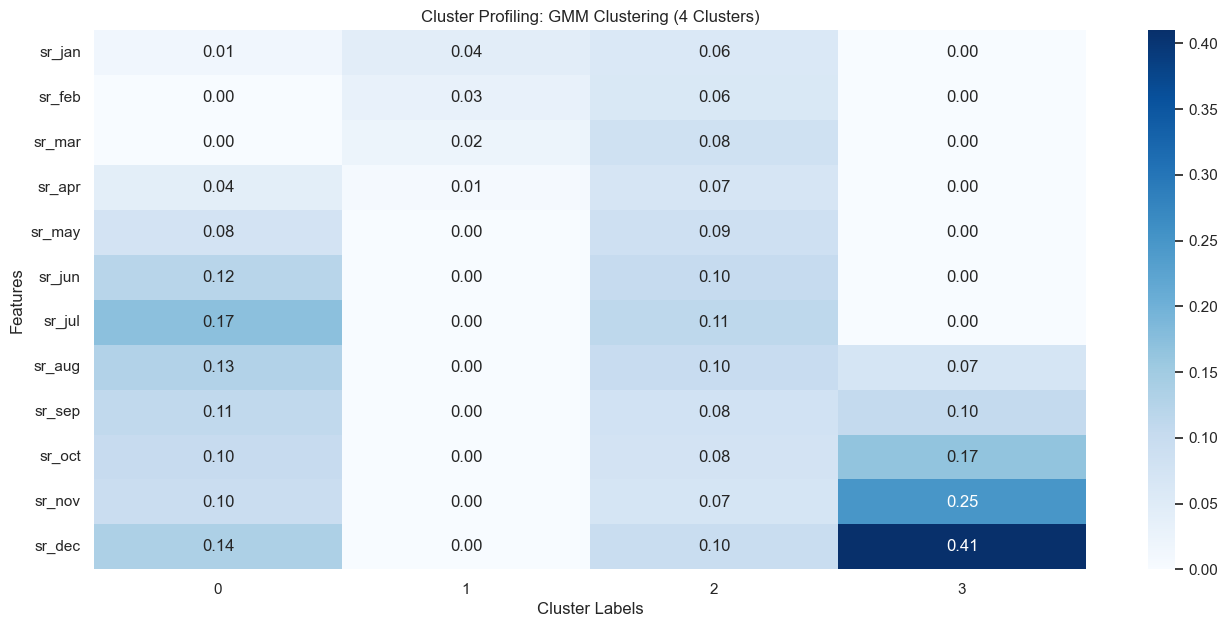

In [43]:
# Now let's try GMM
# We know that K means with 4 clusters worked well
gmm = GaussianMixture(n_components=4, covariance_type='full', random_state=94)
gmm_labels_4 = gmm.fit_predict(df_seasonal)
df_value_based_with_clusters = df_seasonal.copy()
df_value_based_with_clusters['cluster'] = gmm_labels_4
cluster_profile_orig = df_value_based_with_clusters.groupby('cluster').mean()
display(cluster_profile_orig.T)
plt.figure(figsize=(16,7))
sns.heatmap(cluster_profile_orig.T, cmap="Blues", annot=True, fmt=".2f")
plt.title("Cluster Profiling: GMM Clustering (4 Clusters)")
plt.xlabel("Cluster Labels")
plt.ylabel("Features")
plt.show()



cluster,0,1,2,3,4
sr_jan,0.000000,0.080947,0.057061,0.000000,0.037855
sr_feb,0.000000,0.084834,0.057336,0.000000,0.022732
sr_mar,0.000000,0.143125,0.078255,0.000000,0.000000
sr_apr,0.022075,0.099835,0.067842,0.000000,0.000000
sr_may,0.000000,0.113710,0.085569,0.000000,0.000000
sr_jun,0.128889,0.088764,0.103620,0.000000,0.000000
sr_jul,0.226844,0.008233,0.119994,0.000000,0.000000
sr_aug,0.140672,0.049351,0.102551,0.070766,0.000000
sr_sep,0.123328,0.071291,0.080942,0.104568,0.000000
sr_oct,0.111537,0.074378,0.076873,0.165316,0.000000


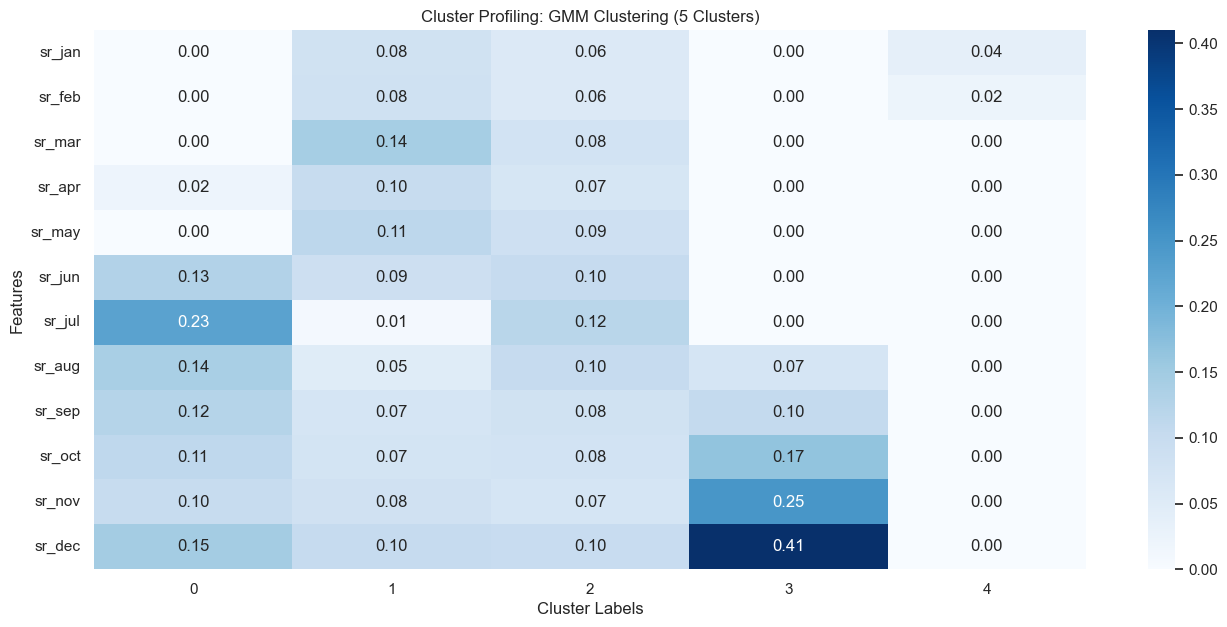

In [46]:
# Now let's try GMM
# We know that K means with 4 clusters worked well
gmm = GaussianMixture(n_components=5, covariance_type='full', random_state=94)
gmm_labels_4 = gmm.fit_predict(df_seasonal)
df_value_based_with_clusters = df_seasonal.copy()
df_value_based_with_clusters['cluster'] = gmm_labels_4
cluster_profile_orig = df_value_based_with_clusters.groupby('cluster').mean()
display(cluster_profile_orig.T)
plt.figure(figsize=(16,7))
sns.heatmap(cluster_profile_orig.T, cmap="Blues", annot=True, fmt=".2f")
plt.title("Cluster Profiling: GMM Clustering (5 Clusters)")
plt.xlabel("Cluster Labels")
plt.ylabel("Features")
plt.show()



## Cluster Profilling

  Cluster 0: 490 customers
  Cluster 1: 8,897 customers
  Cluster 2: 6,993 customers
  Cluster 3: 194 customers


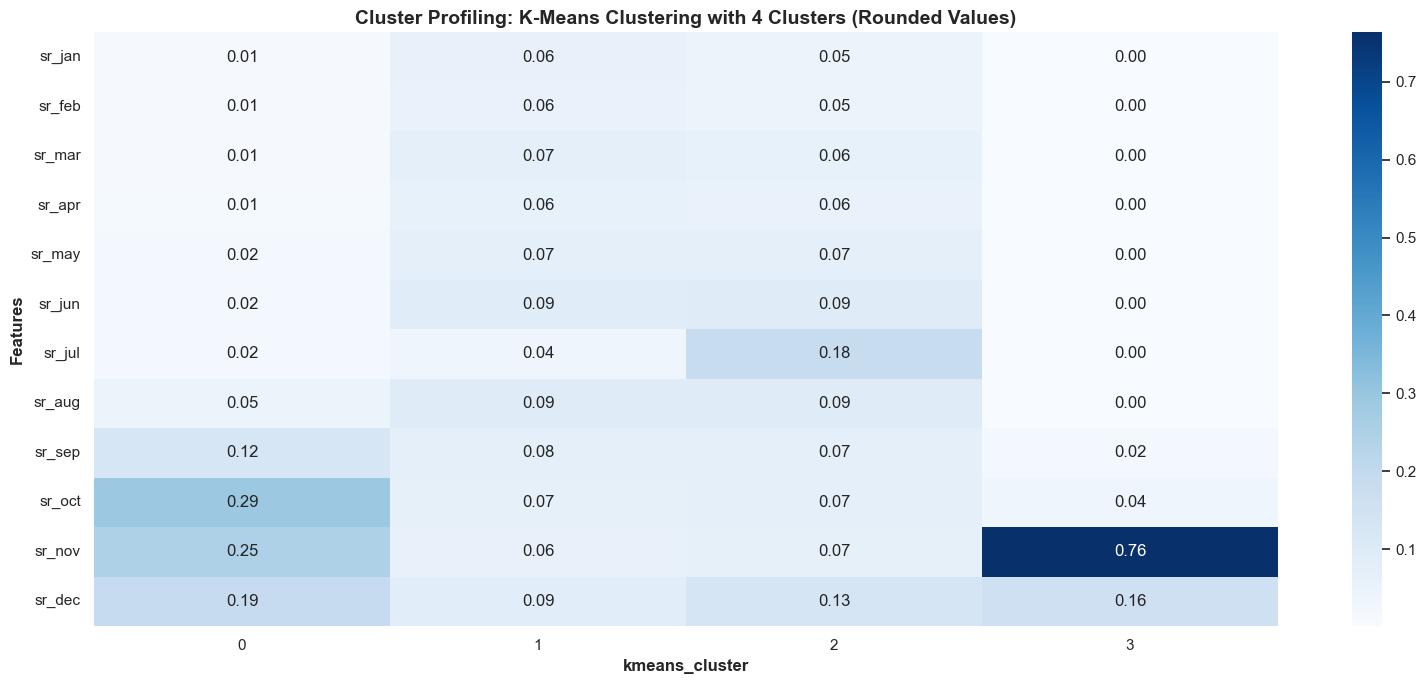

In [50]:
#Final clustering kmeans with 4 clusters
km = KMeans(n_clusters=4, init="k-means++", random_state=94)
km_labels_4 = km.fit_predict(df_seasonal)
print(f"  Cluster 0: {np.sum(km_labels_4 == 0):,} customers")
print(f"  Cluster 1: {np.sum(km_labels_4 == 1):,} customers")
print(f"  Cluster 2: {np.sum(km_labels_4 == 2):,} customers")
print(f"  Cluster 3: {np.sum(km_labels_4 == 3):,} customers")

# add kmeans cluster labels to df
df_seasonal['kmeans_cluster'] = km_labels_4

features_to_cluster = df_seasonal.columns.drop('kmeans_cluster')
# Inverse transform to get original scale
df_original_scale = pd.DataFrame(
    scaler.inverse_transform(df_seasonal[features_to_cluster]),
    columns=features_to_cluster,
    index=df_seasonal.index
)

# Add cluster labels
df_original_scale['kmeans_cluster'] = df_seasonal['kmeans_cluster'].values
# Calculate mean per cluster (in original scale)
cluster_profile_original = df_original_scale.groupby('kmeans_cluster')[features_to_cluster].mean()


plt.figure(figsize=(16, 7))
sns.heatmap(cluster_profile_original.T, cmap="Blues", annot=True, fmt=".2f")
plt.title("Cluster Profiling: K-Means Clustering with 4 Clusters (Rounded Values)", 
          fontweight='bold', fontsize=14)
plt.xlabel("kmeans_cluster", fontweight='bold')
plt.ylabel("Features", fontweight='bold')
plt.tight_layout()
plt.show()


### Purchasing Patterns by Cluster

Based on the K-means clustering with 4 clusters the purchasing behavior can be summarized as follows:

#### 1. **Fall/Holiday Shoppers  (Cluster 0)**
- **Pattern**: Target between September and Nov with holiday previous and early bird discount. We have October (29%) of shopping.
- For this we could start campaigns in early september.



#### 2. **Year Round Customers (Cluster 1)**
- **Pattern**: Customers who has a consistent engagement year-round, loyalty programs

#### 3. **Summer Customers (Cluster 2)**
- **Pattern**: Summer promotions, vacation-related products


#### 3. **Nov Customers (Cluster 3)**
- **Pattern**: Aggressive Nov campaings. Although we just have 194 customers in this clusters, we have 76% of their spending in ONE month is remarkable. In a business, we know exaclty when to target them, nov campaigns for example.

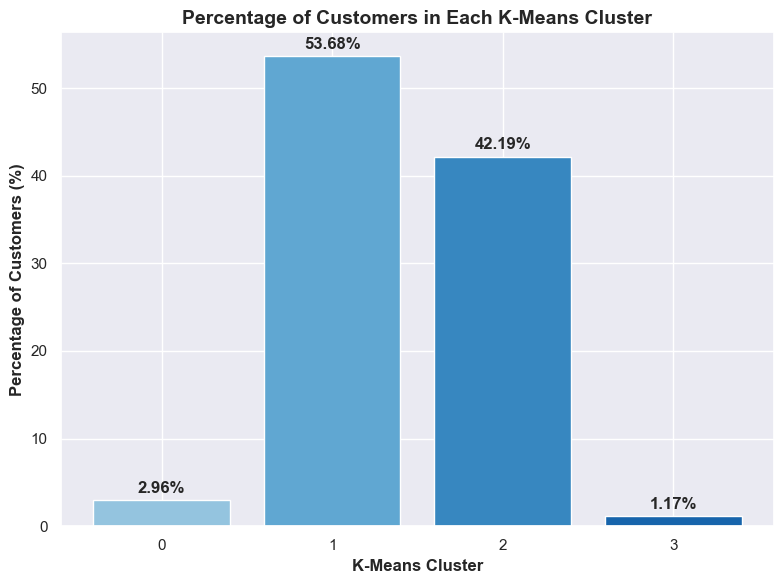

In [51]:
# Please give me a some beauty graph to visualize the clusters and their percentage of customers
cluster_counts = df_seasonal['kmeans_cluster'].value_counts().sort_index()
cluster_percentages = (cluster_counts / cluster_counts.sum()) * 100
fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.bar(cluster_percentages.index.astype(str), cluster_percentages.values, color=cm.Blues(np.linspace(0.4, 0.8, len(cluster_percentages))))
ax.set_xlabel('K-Means Cluster', fontweight='bold')
ax.set_ylabel('Percentage of Customers (%)', fontweight='bold')
ax.set_title('Percentage of Customers in Each K-Means Cluster', fontweight='bold', fontsize=14)
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}%',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom', fontweight='bold')
plt.tight_layout()
plt.show()

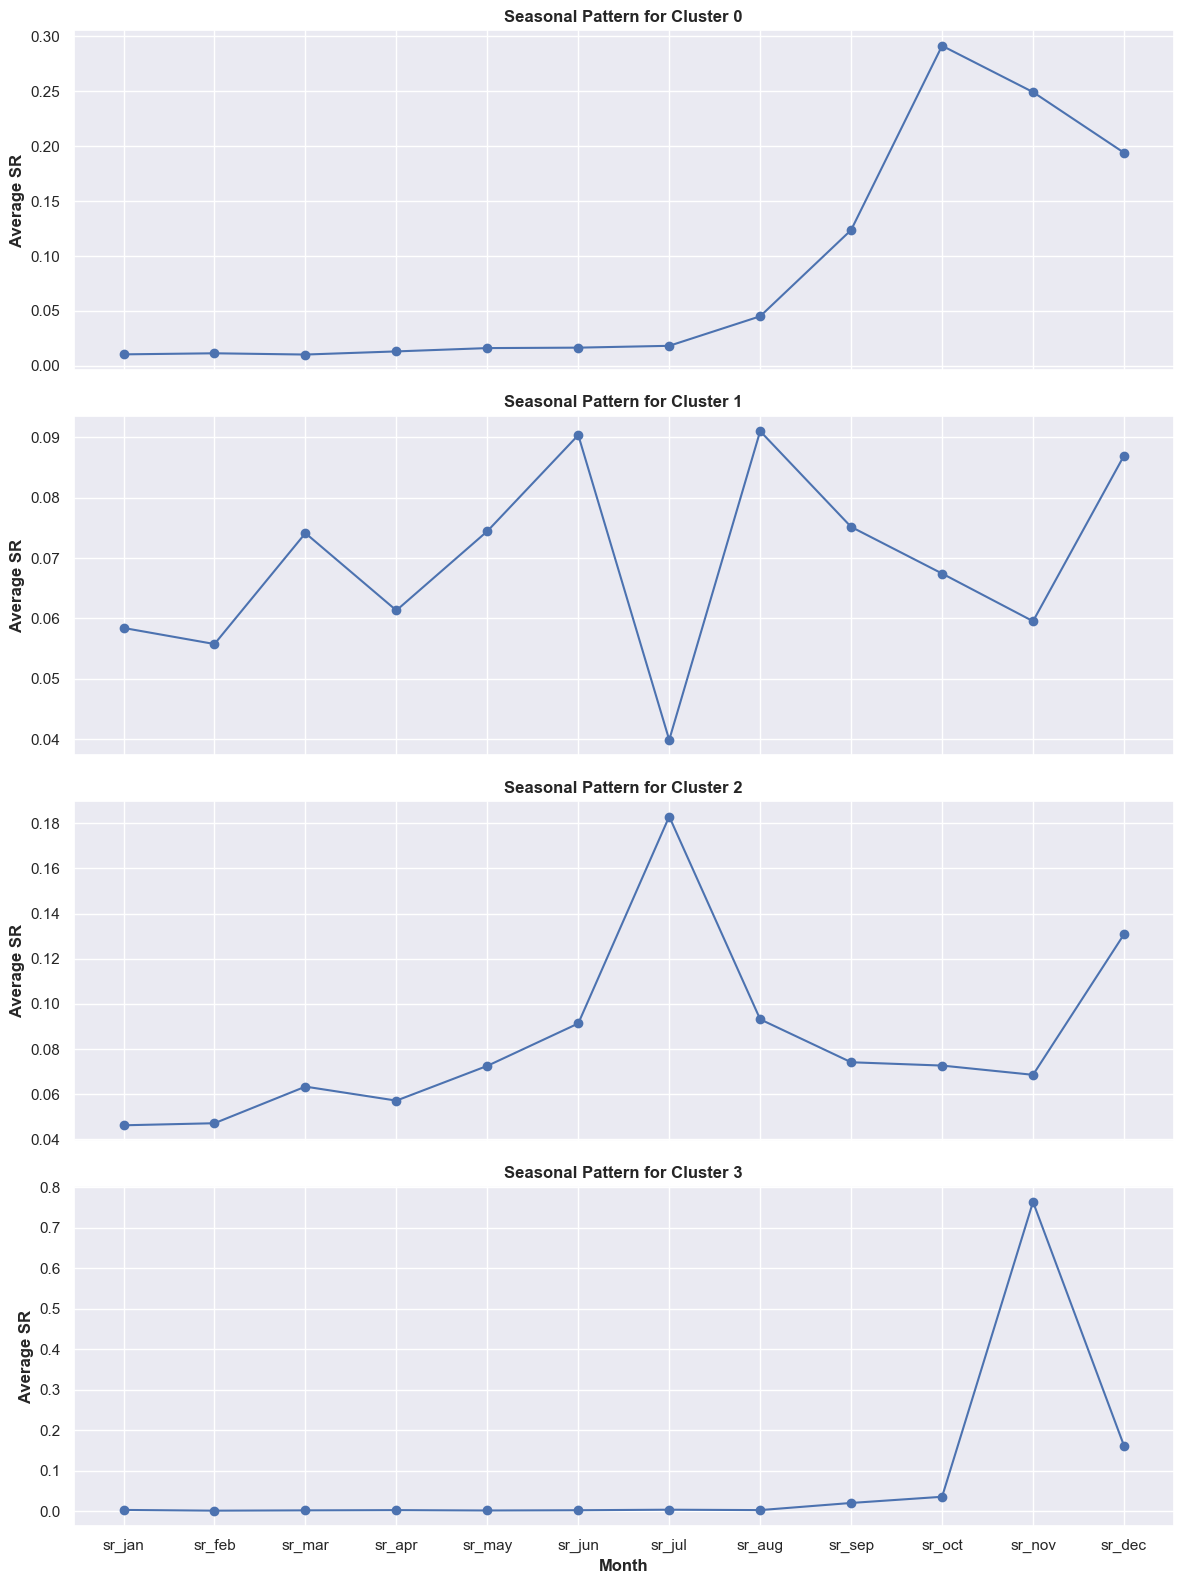

In [52]:

# But I want to see the seasonal patterns for each cluster
n_clusters = df_seasonal['kmeans_cluster'].nunique()
fig, axes = plt.subplots(n_clusters, 1, figsize=(12, 4 * n_clusters), sharex=True)
for cluster in range(n_clusters):
    cluster_data = df_seasonal[df_seasonal['kmeans_cluster'] == cluster]
    mean_pattern = cluster_data.drop(columns='kmeans_cluster').mean()
    axes[cluster].plot(mean_pattern.index, mean_pattern.values, marker='o')
    axes[cluster].set_title(f'Seasonal Pattern for Cluster {cluster}', fontweight='bold')
    axes[cluster].set_ylabel('Average SR', fontweight='bold')
    axes[cluster].grid(True)
axes[-1].set_xlabel('Month', fontweight='bold')
plt.tight_layout()
plt.show()

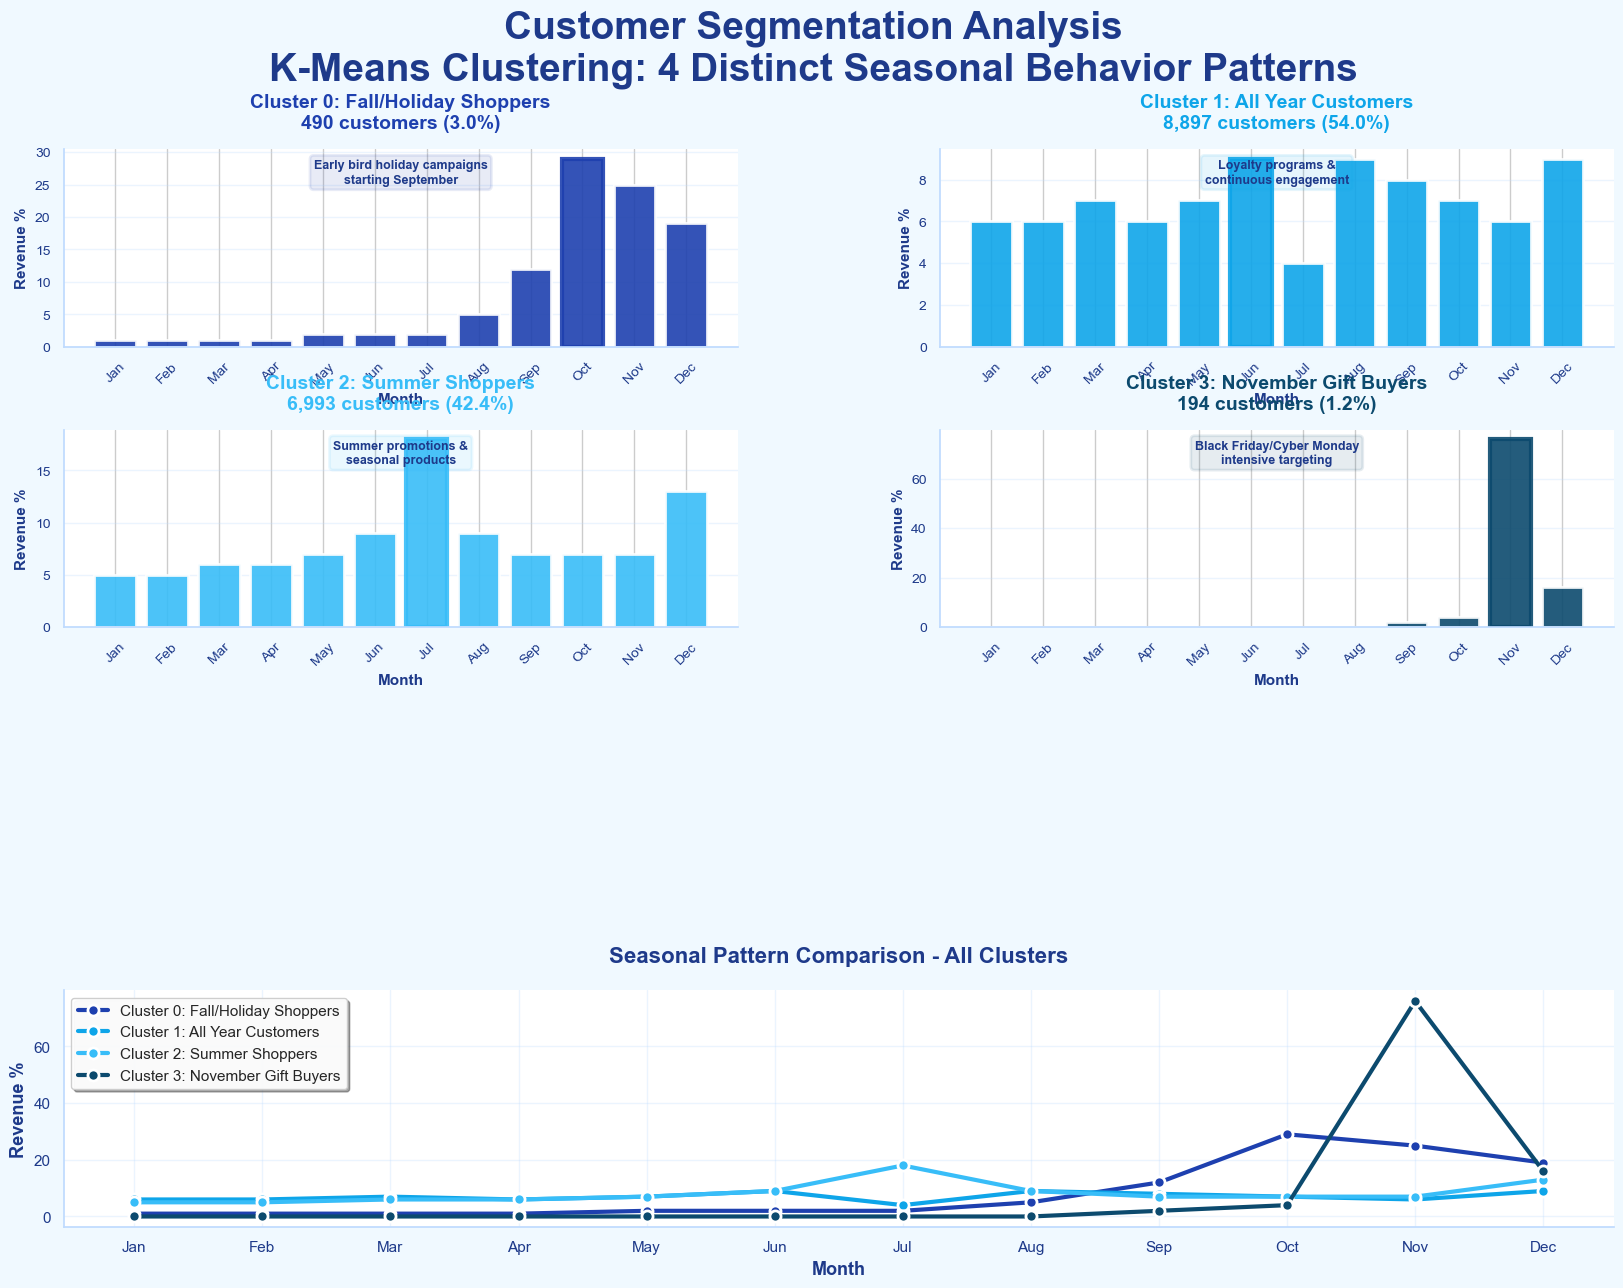

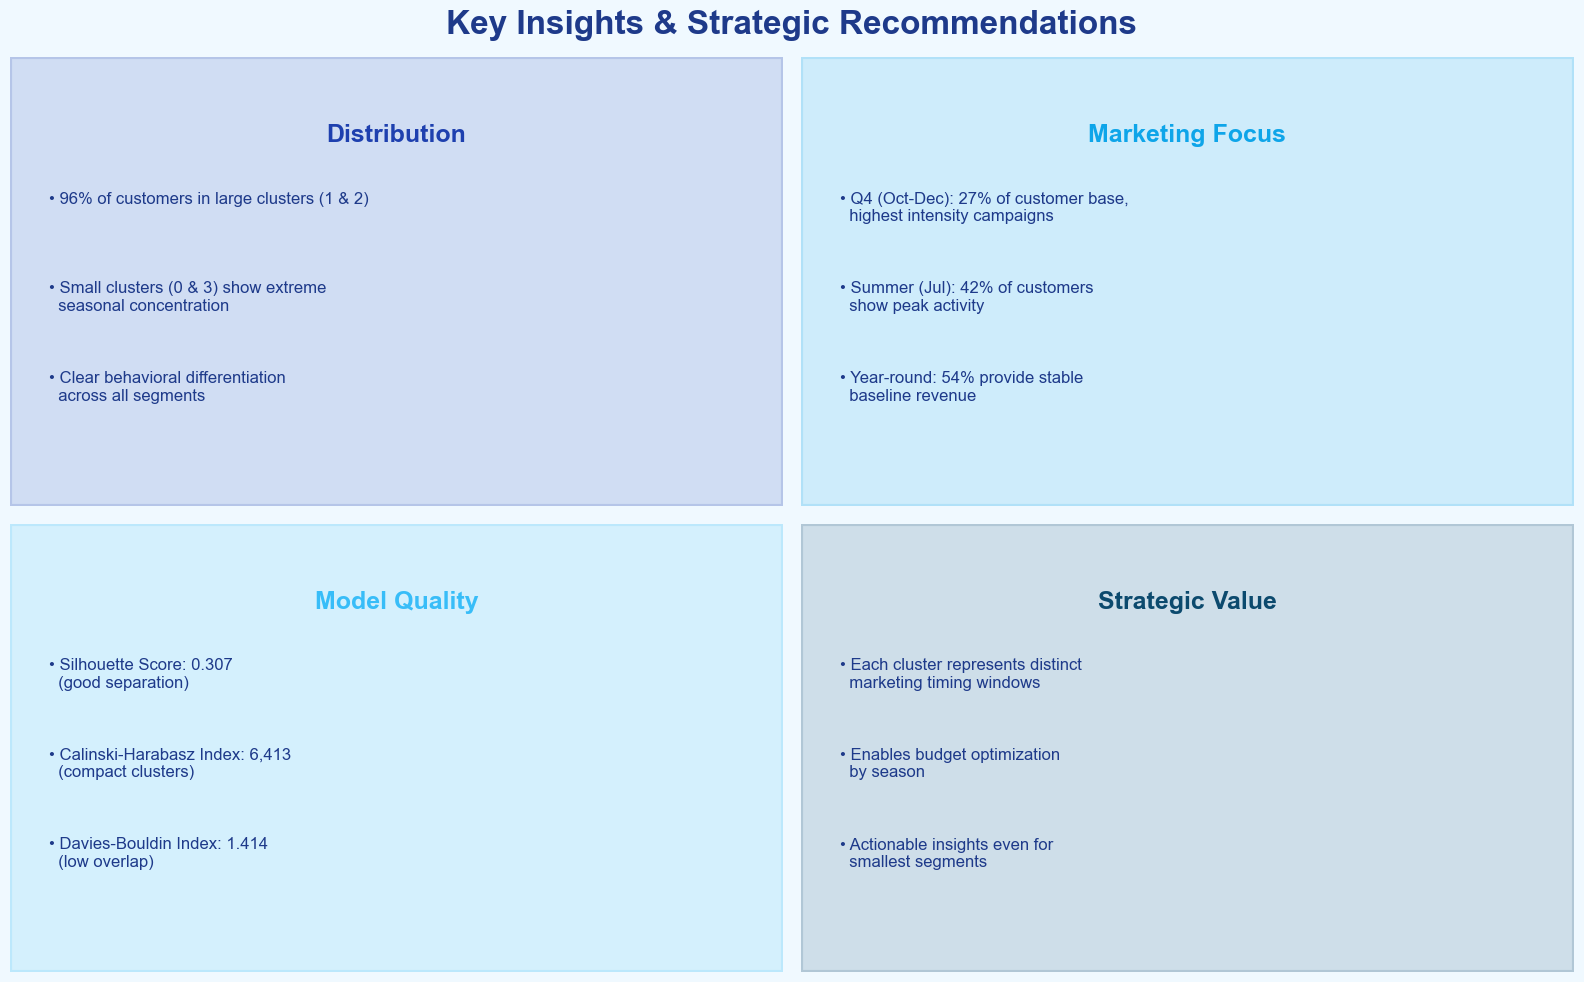

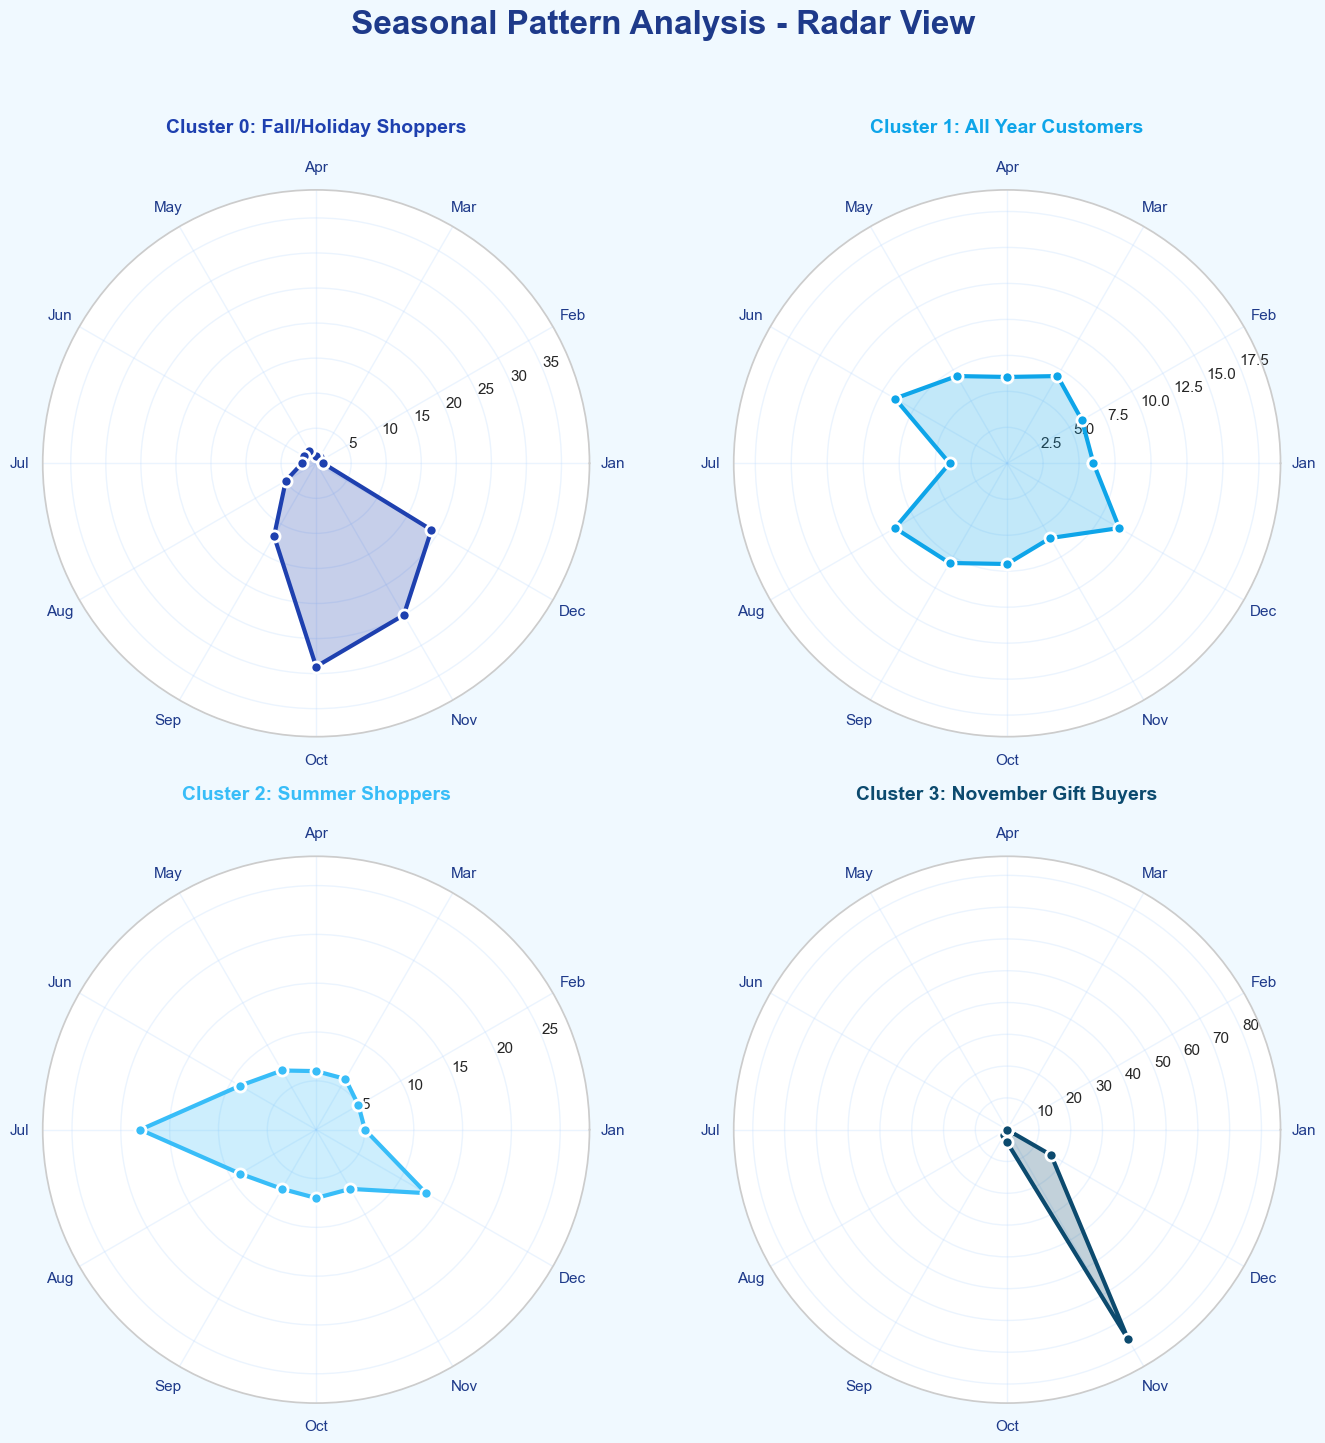

All visualizations saved successfully!
   - seasonal_clusters_analysis.png
   - seasonal_clusters_insights.png
   - seasonal_clusters_radar.png


In [55]:
from matplotlib.patches import Rectangle
from matplotlib import gridspec

# Set style and color palette
sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

# Define blue color palette
colors = {
    'cluster_0': '#1e40af',  # Deep blue
    'cluster_1': '#0ea5e9',  # Sky blue
    'cluster_2': '#38bdf8',  # Light blue
    'cluster_3': '#0c4a6e',  # Navy blue
    'background': '#f0f9ff',
    'text': '#1e3a8a',
    'grid': '#bfdbfe'
}

# Data for each cluster (monthly revenue percentages)
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

cluster_data = {
    'Cluster 0: Fall/Holiday Shoppers\n490 customers (3.0%)': 
        [1, 1, 1, 1, 2, 2, 2, 5, 12, 29, 25, 19],
    'Cluster 1: All Year Customers\n8,897 customers (54.0%)': 
        [6, 6, 7, 6, 7, 9, 4, 9, 8, 7, 6, 9],
    'Cluster 2: Summer Shoppers\n6,993 customers (42.4%)': 
        [5, 5, 6, 6, 7, 9, 18, 9, 7, 7, 7, 13],
    'Cluster 3: November Gift Buyers\n194 customers (1.2%)': 
        [0, 0, 0, 0, 0, 0, 0, 0, 2, 4, 76, 16]
}

cluster_colors = [colors['cluster_0'], colors['cluster_1'], 
                  colors['cluster_2'], colors['cluster_3']]

cluster_strategies = [
    "Early bird holiday campaigns\nstarting September",
    "Loyalty programs &\ncontinuous engagement",
    "Summer promotions &\nseasonal products",
    "Black Friday/Cyber Monday\nintensive targeting"
]

# Create main figure with custom layout
fig = plt.figure(figsize=(20, 14), facecolor=colors['background'])
gs = gridspec.GridSpec(4, 2, figure=fig, hspace=0.4, wspace=0.3, 
                       height_ratios=[1, 1, 1, 1.2])

# Title
fig.suptitle('Customer Segmentation Analysis\nK-Means Clustering: 4 Distinct Seasonal Behavior Patterns', 
             fontsize=28, fontweight='bold', color=colors['text'], y=0.98)

# Plot individual cluster charts (2x2 grid)
for idx, (cluster_name, values) in enumerate(cluster_data.items()):
    row = idx // 2
    col = idx % 2
    ax = fig.add_subplot(gs[row, col])
    
    # Create bars
    bars = ax.bar(months, values, color=cluster_colors[idx], 
                  edgecolor='white', linewidth=2, alpha=0.9)
    
    # Customize appearance
    ax.set_facecolor('white')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color(colors['grid'])
    ax.spines['bottom'].set_color(colors['grid'])
    ax.grid(axis='y', alpha=0.3, color=colors['grid'])
    ax.set_axisbelow(True)
    
    # Labels and title
    ax.set_ylabel('Revenue %', fontsize=11, fontweight='bold', color=colors['text'])
    ax.set_xlabel('Month', fontsize=11, fontweight='bold', color=colors['text'])
    ax.set_title(cluster_name, fontsize=14, fontweight='bold', 
                color=cluster_colors[idx], pad=15)
    
    # Add strategy text box
    strategy_text = cluster_strategies[idx]
    ax.text(0.5, 0.95, strategy_text, transform=ax.transAxes,
           fontsize=9, verticalalignment='top', horizontalalignment='center',
           bbox=dict(boxstyle='round', facecolor=cluster_colors[idx], 
                    alpha=0.1, edgecolor=cluster_colors[idx], linewidth=2),
           color=colors['text'], fontweight='bold')
    
    # Rotate x-axis labels
    ax.tick_params(axis='x', rotation=45, labelsize=10, colors=colors['text'])
    ax.tick_params(axis='y', labelsize=10, colors=colors['text'])
    
    # Highlight maximum value
    max_idx = values.index(max(values))
    bars[max_idx].set_edgecolor(cluster_colors[idx])
    bars[max_idx].set_linewidth(3)

# Comparison line chart (bottom, spanning both columns)
ax_comparison = fig.add_subplot(gs[3, :])
ax_comparison.set_facecolor('white')

# Plot all clusters
for idx, (cluster_name, values) in enumerate(cluster_data.items()):
    label = cluster_name.split('\n')[0]
    ax_comparison.plot(months, values, marker='o', markersize=8, 
                      linewidth=3, label=label, color=cluster_colors[idx],
                      markeredgecolor='white', markeredgewidth=2)

# Customize comparison chart
ax_comparison.spines['top'].set_visible(False)
ax_comparison.spines['right'].set_visible(False)
ax_comparison.spines['left'].set_color(colors['grid'])
ax_comparison.spines['bottom'].set_color(colors['grid'])
ax_comparison.grid(True, alpha=0.3, color=colors['grid'])
ax_comparison.set_axisbelow(True)

ax_comparison.set_xlabel('Month', fontsize=13, fontweight='bold', color=colors['text'])
ax_comparison.set_ylabel('Revenue %', fontsize=13, fontweight='bold', color=colors['text'])
ax_comparison.set_title('Seasonal Pattern Comparison - All Clusters', 
                       fontsize=16, fontweight='bold', color=colors['text'], pad=20)

ax_comparison.legend(loc='upper left', frameon=True, fancybox=True, 
                    shadow=True, fontsize=11, framealpha=0.95)
ax_comparison.tick_params(axis='both', labelsize=11, colors=colors['text'])

plt.tight_layout()
plt.savefig('seasonal_clusters_analysis.png', dpi=300, bbox_inches='tight', 
            facecolor=colors['background'])
plt.show()


fig2, axes = plt.subplots(2, 2, figsize=(16, 10), facecolor=colors['background'])
fig2.suptitle('Key Insights & Strategic Recommendations', 
              fontsize=24, fontweight='bold', color=colors['text'], y=0.98)

insights = [
    {
        'title': 'Distribution',
        'points': [
            '• 96% of customers in large clusters (1 & 2)',
            '• Small clusters (0 & 3) show extreme\n  seasonal concentration',
            '• Clear behavioral differentiation\n  across all segments'
        ]
    },
    {
        'title': 'Marketing Focus',
        'points': [
            '• Q4 (Oct-Dec): 27% of customer base,\n  highest intensity campaigns',
            '• Summer (Jul): 42% of customers\n  show peak activity',
            '• Year-round: 54% provide stable\n  baseline revenue'
        ]
    },
    {
        'title': 'Model Quality',
        'points': [
            '• Silhouette Score: 0.307\n  (good separation)',
            '• Calinski-Harabasz Index: 6,413\n  (compact clusters)',
            '• Davies-Bouldin Index: 1.414\n  (low overlap)'
        ]
    },
    {
        'title': 'Strategic Value',
        'points': [
            '• Each cluster represents distinct\n  marketing timing windows',
            '• Enables budget optimization\n  by season',
            '• Actionable insights even for\n  smallest segments'
        ]
    }
]

for idx, ax in enumerate(axes.flat):
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 10)
    ax.axis('off')
    
    # Background box with gradient effect
    rect = Rectangle((0, 0), 10, 10, facecolor=cluster_colors[idx], 
                     alpha=0.15, edgecolor=cluster_colors[idx], linewidth=3)
    ax.add_patch(rect)
    
    # Title
    ax.text(5, 8.5, insights[idx]['title'], fontsize=18, fontweight='bold',
           ha='center', va='top', color=cluster_colors[idx])
    
    # Points
    y_pos = 7
    for point in insights[idx]['points']:
        ax.text(0.5, y_pos, point, fontsize=12, ha='left', va='top',
               color=colors['text'], fontweight='normal')
        y_pos -= 2

plt.tight_layout()
plt.savefig('seasonal_clusters_insights.png', dpi=300, bbox_inches='tight',
            facecolor=colors['background'])
plt.show()



fig3 = plt.figure(figsize=(14, 14), facecolor=colors['background'])
fig3.suptitle('Seasonal Pattern Analysis - Radar View', 
              fontsize=24, fontweight='bold', color=colors['text'], y=1.03)

# Create 4 subplots for radar charts
for idx, (cluster_name, values) in enumerate(cluster_data.items()):
    ax = fig3.add_subplot(2, 2, idx+1, projection='polar')
    
    # Prepare data for polar plot
    angles = np.linspace(0, 2 * np.pi, len(months), endpoint=False).tolist()
    values_plot = values + [values[0]]  # Complete the circle
    angles += angles[:1]
    
    # Plot
    ax.plot(angles, values_plot, 'o-', linewidth=3, color=cluster_colors[idx],
           markersize=8, markeredgecolor='white', markeredgewidth=2)
    ax.fill(angles, values_plot, alpha=0.25, color=cluster_colors[idx])
    
    # Customize
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(months, fontsize=11, color=colors['text'])
    ax.set_ylim(0, max(values) + 10)
    ax.set_title(cluster_name.split('\n')[0], fontsize=14, 
                fontweight='bold', color=cluster_colors[idx], pad=20)
    ax.grid(True, color=colors['grid'], alpha=0.3)
    ax.set_facecolor('white')

plt.tight_layout()
plt.savefig('seasonal_clusters_radar.png', dpi=300, bbox_inches='tight',
            facecolor=colors['background'])
plt.show()

print("All visualizations saved successfully!")
print("   - seasonal_clusters_analysis.png")
print("   - seasonal_clusters_insights.png")
print("   - seasonal_clusters_radar.png")